In [140]:
import cv2
import os
import numpy as np
import skimage
from skimage import io, transform, color, filters, data, morphology, measure
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

def load_images_from_folder(folder):
    images = []
    images_name = []
    for filename in os.listdir(folder):
        img = io.imread(os.path.join(folder,filename))
        if img is not None:
            images.append(img)
            images_name.append(filename)
    
    images_df = pd.DataFrame({"name": images_name,
                             "image": images})
    #print(images_df)
    return images_df

def display(np_image):
    """
    This is a display function that we have added to show numpy images at full size
    If you pass in an image with 3 channels, it will be displayed in RGB
    If you passn in an image with 1 channel, it will be displayed in grayscale
    """
    dpi = matplotlib.rcParams['figure.dpi']
    if len(np_image.shape) == 3:
        height, width, depth = np_image.shape
    else:
        height, width = np_image.shape

    # What size does the figure need to be in inches to fit the image?
    figsize = width / float(dpi), height / float(dpi)

    # Create a figure of the right size with one axes that takes up the full figure
    fig = plt.figure(figsize=figsize)
    ax = fig.add_axes([0, 0, 1, 1])

    # Hide spines, ticks, etc.
    ax.axis('off')
    
    # Display the image in either RGB or grayscale (depending on the amount of dimensions)
    if (len(np_image.shape) >= 3):
        ax.imshow(np_image)
    else:
        ax.imshow(np_image, cmap='gray')

    plt.show()

all_images_df = load_images_from_folder('../dataset-images/dataset1')

#print(len(list_images))
#print(list_images[0])
#print(list_images_name)
print('----------done---------')

----------done---------


In [189]:


#display(list_images[0])
#zipcode = list_images[0]
#zipcode = zipcode *-1
#gray = color.rgb2gray(zipcode)#
#display(gray)
#thresh = filters.threshold_otsu(gray)
#binary = gray > thresh
#display(binary)
#label_image = measure.label(binary)
#display(label_image)

#props = measure.regionprops_table(label_image, properties=['label', 'area', 'bbox', 'bbox_area', 'perimeter', 
#                                                           'convex_area', 'eccentricity', 'equivalent_diameter', 
#                                                           'euler_number', 'extent', 'feret_diameter_max', 'filled_area',
#                                                           'orientation', 'perimeter_crofton', 'solidity'])
#data = pd.DataFrame(props)

#print(data)

#for region in measure.regionprops_table(label_image):
 #   region
    #print(region.properties)
    #print(region.area, ' // ', region.centroid, ' // ', region.perimeter, ' // ', region.filled_area)

df = None
error_counts = 0

image_properties = ['label','area', 'bbox', 'bbox_area', 'centroid', 'perimeter', 
            'convex_area', 'eccentricity', 'equivalent_diameter', 'euler_number',
            'extent', 'feret_diameter_max', 'filled_area',
            'perimeter_crofton', 'solidity', 'local_centroid', 'major_axis_length',
            'minor_axis_length', 'moments_hu', 'orientation']

# 'moments_hu', 'orientation' 'euler_number',

def initialize_image(image, image_name):
    zipcode = image
    zipcode = zipcode *-1
    gray = color.rgb2gray(zipcode)
    thresh = filters.threshold_otsu(gray)
    binary = gray > thresh
    #display(binary)
    
    # remove the white small spots/dots
    binary = morphology.binary_opening(binary)
    #display(binary)
    
    # make the white zip numbers thicker
    binary = morphology.binary_dilation(binary)
    #display(binary)
    
    # some numbers may have holes in it. That could seperate the number in 2 different labels. with closing the gap will be closed
    binary = morphology.binary_closing(binary)
    #display(binary)
    
    # return number back to its original state before it was made thicker. make the numbers thinner
    binary = morphology.binary_erosion(binary)
    #display(binary)
    # return_num=True, connectivity=None
    #print(binary)
    label_image, total_labels = measure.label(binary, return_num=True)
    #display(label_image)
    global image_properties
    props = measure.regionprops_table(label_image, properties=image_properties)
    tmp_df = pd.DataFrame(props)
    
    # filter out labels that have too small areas. these labels are small dots that could not be filled with the opening function
    tmp_df = tmp_df.query('area > 50')
    #print(tmp_df)
    zip_numbers = list(image_name)[:4]
    if len(tmp_df.index) == 4:
        #print('-----------------')
        #print(total_labels)
        tmp_df.insert(0, 'zip_numbers', zip_numbers)
    else:
        return None
        
    return tmp_df

print('----------done---------')

----------done---------


In [190]:
result = pd.DataFrame()

for i in range(0, len(all_images_df.index)):
    image_name = all_images_df.iloc[i,0]
    image = all_images_df.iloc[i,1]
    tmp_result = initialize_image(image, image_name)
    result = pd.concat([result, tmp_result])

result.reset_index(inplace=True)
result.drop(columns=['index', 'label'], inplace=True)
result

,zip_numbers,area,bbox-0,bbox-1,bbox-2,bbox-3,bbox_area,centroid-0,centroid-1,perimeter,...,major_axis_length,minor_axis_length,moments_hu-0,moments_hu-1,moments_hu-2,moments_hu-3,moments_hu-4,moments_hu-5,moments_hu-6,orientation
0,1,287,0,6,32,26,640,15.310105,17.933798,89.840620,...,30.408628,17.616293,0.268950,0.017899,0.013183,0.000420,-2.683356e-07,-0.000042,-9.497167e-07,-0.049638
1,0,296,0,38,32,58,640,16.425676,47.395270,143.781746,...,37.565785,23.184497,0.411467,0.034031,0.001471,0.000066,-1.990600e-08,-0.000005,5.877535e-09,0.046295
2,0,300,0,70,32,91,672,16.080000,79.313333,145.781746,...,38.187484,23.086854,0.414851,0.037159,0.000701,0.000134,1.355049e-08,-0.000022,-3.859056e-08,0.131159
3,0,346,0,101,32,123,704,15.502890,111.341040,151.781746,...,38.646650,25.671956,0.388839,0.022724,0.000076,0.000091,-9.519663e-10,0.000008,7.537652e-09,0.109576
4,1,318,0,4,32,29,800,18.584906,14.393082,103.840620,...,40.612946,15.840432,0.373493,0.075548,0.010167,0.001006,-6.020065e-07,-0.000052,3.158651e-06,0.378889
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
955,2,345,0,102,32,124,704,17.214493,111.115942,120.225397,...,42.337704,18.416269,0.386167,0.069318,0.004804,0.000744,1.386400e-06,0.000195,-2.293072e-07,0.156394
956,5,279,0,7,32,24,544,14.326165,14.627240,109.396970,...,41.787009,14.656867,0.439287,0.117676,0.004865,0.001923,5.867712e-06,0.000648,4.255932e-07,0.038346
957,3,312,0,38,32,59,672,15.310897,48.391026,122.953319,...,40.042129,17.197767,0.380436,0.068613,0.003335,0.000618,-5.978847e-07,-0.000150,6.565419e-07,0.134856
958,8,431,0,69,32,92,736,16.447796,78.846868,150.994949,...,34.289232,21.607479,0.238201,0.010567,0.000232,0.000038,1.728684e-09,0.000004,3.095958e-09,0.125511


In [191]:
result['zip_numbers'] = result['zip_numbers'].astype(int)
result.describe(include="all")

,zip_numbers,area,bbox-0,bbox-1,bbox-2,bbox-3,bbox_area,centroid-0,centroid-1,perimeter,...,major_axis_length,minor_axis_length,moments_hu-0,moments_hu-1,moments_hu-2,moments_hu-3,moments_hu-4,moments_hu-5,moments_hu-6,orientation
count,960.000000,960.000000,960.000000,960.000000,960.000000,960.000000,960.000000,960.000000,960.000000,960.000000,...,960.000000,960.000000,960.000000,960.000000,9.600000e+02,960.000000,9.600000e+02,960.000000,9.600000e+02,960.000000
mean,3.942708,332.423958,0.003125,54.134375,31.995833,74.677083,657.215625,15.576430,63.847869,117.157728,...,36.444834,18.249425,0.320020,0.040553,4.261452e-03,0.000988,4.006409e-06,0.000127,6.496319e-07,0.058086
std,2.741914,38.525623,0.055843,35.924897,0.064449,35.901933,75.798099,1.646801,35.806607,17.325586,...,3.580145,2.538358,0.062327,0.025356,5.194869e-03,0.001379,1.541752e-05,0.000330,1.032642e-05,0.167079
min,0.000000,203.000000,0.000000,1.000000,31.000000,20.000000,352.000000,11.506623,12.000000,81.254834,...,28.065655,8.955324,0.188338,0.003217,1.436339e-07,0.000002,-1.409764e-05,-0.000624,-2.424378e-04,-0.614621
25%,2.000000,301.000000,0.000000,27.250000,32.000000,47.750000,620.000000,14.560205,38.347485,105.296465,...,34.222018,16.727510,0.272610,0.021886,8.010861e-04,0.000156,-7.362563e-11,-0.000001,-4.219631e-08,-0.039348
50%,4.000000,333.000000,0.000000,54.000000,32.000000,74.500000,640.000000,15.433922,64.276136,116.778698,...,36.736923,18.214579,0.315562,0.034587,2.506564e-03,0.000477,1.452694e-07,0.000022,8.823401e-09,0.071319
75%,6.000000,359.000000,0.000000,81.000000,32.000000,101.250000,704.000000,16.529212,89.409466,129.231493,...,39.326080,19.800529,0.359501,0.055210,6.194887e-03,0.001226,1.819173e-06,0.000135,6.465412e-07,0.164588
max,9.000000,446.000000,1.000000,106.000000,32.000000,128.000000,960.000000,20.266667,116.496894,167.480231,...,43.520157,26.083379,0.578771,0.203847,5.461427e-02,0.012590,2.240915e-04,0.002822,6.018022e-05,0.478749


In [192]:
X = result.iloc[:,1:]
Y = result.iloc[:,0]

In [236]:
# start feature selection
from sklearn.ensemble import ExtraTreesClassifier
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import pyplot

#apply SelectKBest class to extract top 10 best features
def feature_selection_kbest(X, Y):
    bestfeatures = SelectKBest(k='all')
    fit = bestfeatures.fit(X,Y)
    dfscores = pd.DataFrame(fit.scores_)
    dfcolumns = pd.DataFrame(X.columns)
    #concat two dataframes for better visualization 
    featureScores = pd.concat([dfcolumns,dfscores],axis=1)
    featureScores.columns = ['Specs','Score']  #naming the dataframe columns
    print(featureScores.nlargest(12,'Score'))  #print 10 best features
        
    # plot the scores
    pyplot.bar([i for i in range(len(fit.scores_))], fit.scores_)
    pyplot.show()
    

def feature_selection_trees(X, Y):
    model = ExtraTreesClassifier()
    model.fit(X,Y)
    print(model.feature_importances_) #use inbuilt class feature_importances of tree based classifiers
    #plot graph of feature importances for better visualization
    feat_importances = pd.Series(model.feature_importances_, index=X.columns)
    feat_importances.nlargest(10).plot(kind='barh')
    plt.show()
    

def feature_selection_corr(result):
    #get correlations of each features in dataset
    corrmat = result.corr()
    top_corr_features = corrmat.index
    plt.figure(figsize=(18,18))
    #plot heat map
    g=sns.heatmap(result[top_corr_features].corr(),annot=True,cmap="RdYlGn")

                Specs       Score
20  major_axis_length  317.617133
10       eccentricity  251.543976
12       euler_number  233.811981
18   local_centroid-0  164.964339
6          centroid-0  163.631240
15        filled_area  149.170553
21  minor_axis_length  145.083976
8           perimeter  138.723415
16  perimeter_crofton  131.805329
23       moments_hu-1  120.773865
22       moments_hu-0  105.913114
29        orientation  101.014726


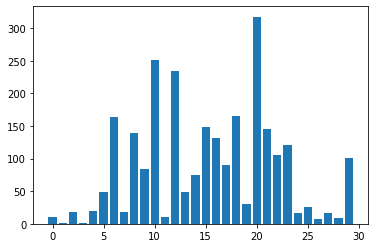

[0.01459801 0.00035901 0.01638191 0.00053334 0.01757702 0.02585171
 0.06534583 0.01977073 0.04671494 0.02574092 0.06473894 0.01428572
 0.07072807 0.02551445 0.03738182 0.04625915 0.04555698 0.03006831
 0.06208101 0.03364276 0.07828053 0.04479259 0.02792111 0.03979497
 0.01915797 0.02153068 0.01650815 0.02167475 0.02337851 0.04383013]


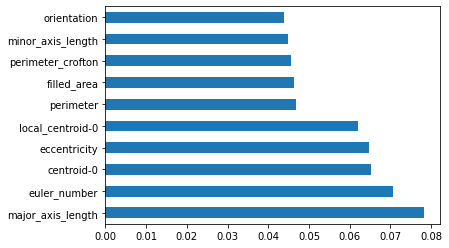

,zip_numbers,area,bbox-0,bbox-1,bbox-2,bbox-3,bbox_area,centroid-0,centroid-1,perimeter,...,major_axis_length,minor_axis_length,moments_hu-0,moments_hu-1,moments_hu-2,moments_hu-3,moments_hu-4,moments_hu-5,moments_hu-6,orientation
0,1,287,0,6,32,26,640,15.310105,17.933798,89.840620,...,30.408628,17.616293,0.268950,0.017899,0.013183,0.000420,-2.683356e-07,-0.000042,-9.497167e-07,-0.049638
1,0,296,0,38,32,58,640,16.425676,47.395270,143.781746,...,37.565785,23.184497,0.411467,0.034031,0.001471,0.000066,-1.990600e-08,-0.000005,5.877535e-09,0.046295
2,0,300,0,70,32,91,672,16.080000,79.313333,145.781746,...,38.187484,23.086854,0.414851,0.037159,0.000701,0.000134,1.355049e-08,-0.000022,-3.859056e-08,0.131159
3,0,346,0,101,32,123,704,15.502890,111.341040,151.781746,...,38.646650,25.671956,0.388839,0.022724,0.000076,0.000091,-9.519663e-10,0.000008,7.537652e-09,0.109576
4,1,318,0,4,32,29,800,18.584906,14.393082,103.840620,...,40.612946,15.840432,0.373493,0.075548,0.010167,0.001006,-6.020065e-07,-0.000052,3.158651e-06,0.378889
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
955,2,345,0,102,32,124,704,17.214493,111.115942,120.225397,...,42.337704,18.416269,0.386167,0.069318,0.004804,0.000744,1.386400e-06,0.000195,-2.293072e-07,0.156394
956,5,279,0,7,32,24,544,14.326165,14.627240,109.396970,...,41.787009,14.656867,0.439287,0.117676,0.004865,0.001923,5.867712e-06,0.000648,4.255932e-07,0.038346
957,3,312,0,38,32,59,672,15.310897,48.391026,122.953319,...,40.042129,17.197767,0.380436,0.068613,0.003335,0.000618,-5.978847e-07,-0.000150,6.565419e-07,0.134856
958,8,431,0,69,32,92,736,16.447796,78.846868,150.994949,...,34.289232,21.607479,0.238201,0.010567,0.000232,0.000038,1.728684e-09,0.000004,3.095958e-09,0.125511


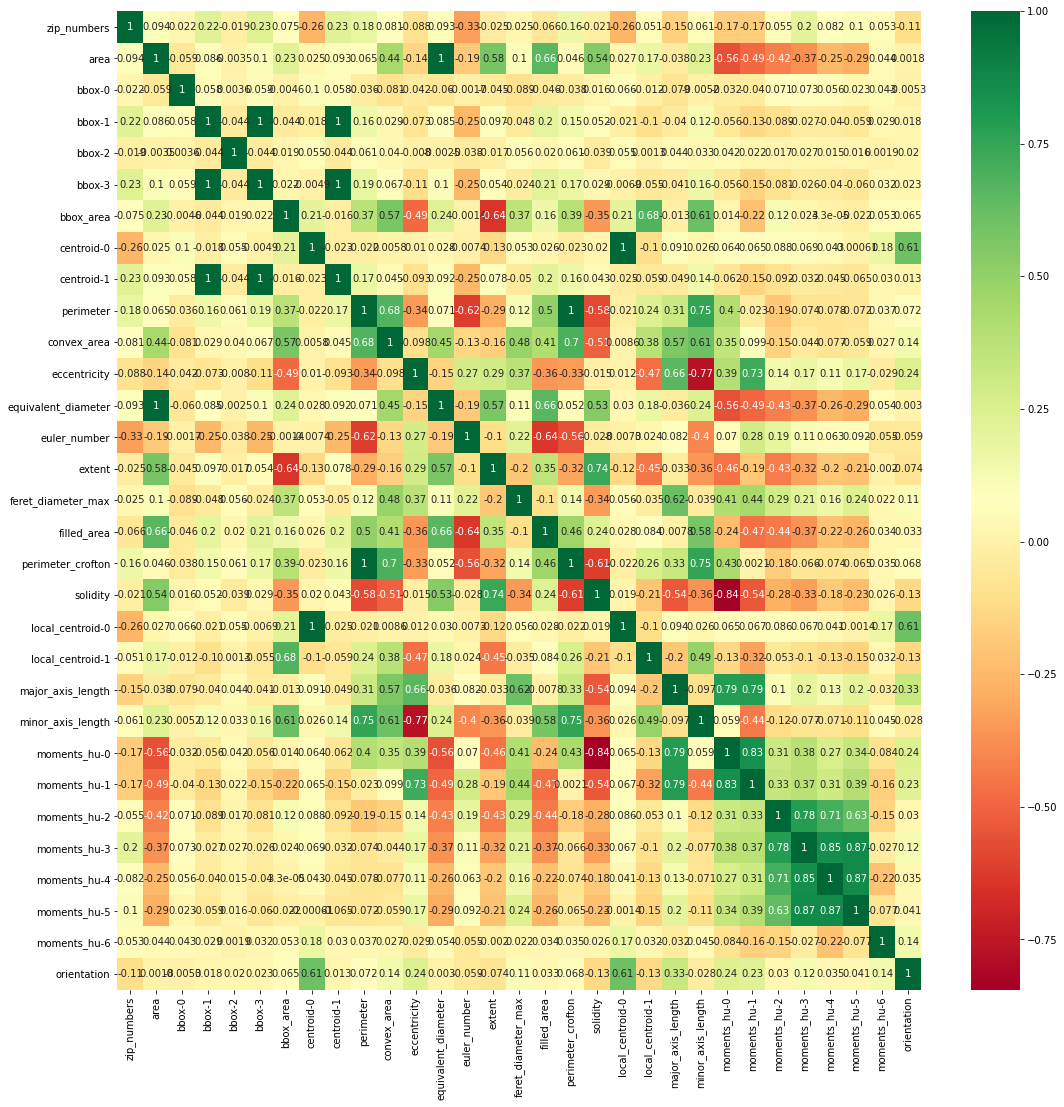

In [237]:
feature_selection_kbest(X, Y)
feature_selection_trees(X, Y)
feature_selection_corr(result)
result

In [285]:
#lets select some features
# ''orientation', moments_hu-1, moments_hu-0
# filled_area, bbox-1, centroid-1, bbox_area, convex_area, bbox-3, perimeter
features = ['major_axis_length', 'minor_axis_length', 'euler_number', 'centroid-0', 'eccentricity', 'local_centroid-0', 'perimeter', 'perimeter_crofton', 'filled_area', 'orientation']
#featuresZip = ['zip_numbers', 'filled_area', 'perimeter', 'perimeter_crofton', 'eccentricity', 'bbox-1', 'solidity', 'extent']
#selected_features = result.loc[:,featuresZip]
#selected_features
# 'filled_area', 'bbox-3', 'perimeter', 'perimeter_crofton', 'bbox-1', 'bbox_area', 'convex_area' -> 0.58
# 'filled_area', 'perimeter', 'perimeter_crofton', 'eccentricity', 'bbox-1', 'solidity', 'bbox-3' -> 0.66
# 'filled_area', 'perimeter', 'perimeter_crofton', 'eccentricity', 'bbox-1', 'solidity', 'extent' -> 0.69/0.7
# 'filled_area', 'perimeter', 'perimeter_crofton', 'eccentricity', 'area', 'solidity', 'extent' ->

#----------------------------------------
# 'major_axis_length', 'euler_number', 'centroid-0', 'eccentricity', 'local_centroid-0', 'perimeter', 'perimeter_crofton', 'filled_area', 'bbox-1', 'centroid-1', 'bbox_area', 'convex_area', 'bbox-3'
# -> 

In [286]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
standardScaler = StandardScaler()
minMaxScaler = MinMaxScaler()


def preprocess(X_train, X_test):
    print('-----Start preprocc----------')
    global features
    X_train[features] = minMaxScaler.fit_transform(X_train[features].to_numpy())
    X_test[features] = minMaxScaler.transform(X_test[features].to_numpy())
    print('---------Preprocess Done--------')
    return X_train, X_test

def splitTrainTest(result):
    # Split data into 50% train and 50% test subsets
    global features
    X_train, X_test, y_train, y_test = train_test_split(
        result[features], result['zip_numbers'], test_size=0.2, random_state=0)
    
    X_train, X_test = preprocess(X_train, X_test)
    return X_train, X_test, y_train, y_test

In [287]:
X_train, X_test, y_train, y_test = splitTrainTest(result)

-----Start preprocc----------
---------Preprocess Done--------


In [288]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

In [296]:
def knn_fit_score(X_train, X_test, y_train, y_test):
    train_samples = len(X_train)
    test_samples = len (X_test)
    neigh = KNeighborsClassifier(n_neighbors=5, weights='distance', metric='chebyshev')
    neigh.fit(X_train, y_train.to_numpy().reshape(train_samples))

    score = neigh.score(X_test, y_test.to_numpy().reshape(test_samples))
    return score

def kfolding_knn(dataset):
    kf = KFold(n_splits=5, shuffle=True)
    global features
    X_training = dataset[features]
    y_training = dataset['zip_numbers']
    k = 1
    for train_index, test_index in kf.split(X_training, y_training):
        
        X_train, X_test = X_training.loc[train_index,:], X_training.loc[test_index,:]
        y_train, y_test = y_training.loc[train_index], y_training.loc[test_index]
        X_train, X_test = preprocess(X_train, X_test)
        
        score = knn_fit_score(X_train, X_test, y_train, y_test)
        print("[fold {0}], score: {1:.5f}".
          format(k, score))
        k = k + 1
        
def searchHyperParams_knn(result):
    print('--------start searching params--------')
    X_train, X_test, y_train, y_test = splitTrainTest(result)
    print('--------splitted train test----------')
    grid_params = {
        'n_neighbors' : [3,5,11,14,19],
        'weights' : ['uniform', 'distance'],
        'metric' : ['euclidean', 'manhattan', 'chebyshev']
    }

    gs = GridSearchCV(
        KNeighborsClassifier(),
        grid_params,
        verbose = 1,
        cv = 3,
        n_jobs = -1
    )
    print('---------grid search started---------')
    gs_results = gs.fit(X_train, y_train)

    print('--------Done--------')
    print('best score:')
    print(gs_results.best_score_)
    print('best estimator:')
    print(gs_results.best_estimator_)
    print('best params:')
    print(gs_results.best_params_)
    
def gaussian_nb_fit_score(result):
    X_train, X_test, y_train, y_test = splitTrainTest(result)
    gnb = GaussianNB()
    gnb.fit(X_train, y_train)

    score = gnb.score(X_test, y_test)
    print(score)
    
def searchHyperParams_svc(result):
    print('--------start searching params--------')
    X_train, X_test, y_train, y_test = splitTrainTest(result)
    print('--------splitted train test----------')
    grid_params = {
        'C': [0.1,1, 10, 100],
        'kernel' : ['linear', 'poly', 'rbf', 'sigmoid'],
        'gamma': [1,0.1,0.01,0.001]
    }

    gs = GridSearchCV(
        SVC(),
        grid_params,
        verbose = 1,
        cv = 3,
        n_jobs = -1
    )
    print('---------grid search started---------')
    gs_results = gs.fit(X_train, y_train)

    print('--------Done--------')
    print('best score:')
    print(gs_results.best_score_)
    print('best estimator:')
    print(gs_results.best_estimator_)
    print('best params:')
    print(gs_results.best_params_)
    
def searchHyperParams_DT(result):
    print('--------start searching params--------')
    X_train, X_test, y_train, y_test = splitTrainTest(result)
    print('--------splitted train test----------')
    grid_params = {
        'criterion': ['gini', 'entropy'],
        'splitter' : ['best', 'random'],
        'max_depth': [1,5,10,20,50,100,150,None],
        'min_samples_split': np.arange(2,5),
        'min_samples_leaf': np.arange(1,5),
        'min_weight_fraction_leaf': np.arange(0,0.5)
    }

    gs = GridSearchCV(
        DecisionTreeClassifier(),
        grid_params,
        verbose = 1,
        cv = 3,
        n_jobs = -1
    )
    print('---------grid search started---------')
    gs_results = gs.fit(X_train, y_train)

    print('--------Done--------')
    print('best score:')
    print(gs_results.best_score_)
    print('best estimator:')
    print(gs_results.best_estimator_)
    print('best params:')
    print(gs_results.best_params_)

def searchHyperParams_RC(result):
    print('--------start searching params--------')
    X_train, X_test, y_train, y_test = splitTrainTest(result)
    print('--------splitted train test----------')
    grid_params = {
        'bootstrap': [True, False],
         'max_depth': [10, 20, 30, 40, None],
         'max_features': ['auto', 'sqrt'],
         'min_samples_leaf': [1, 2, 4],
         'min_samples_split': [2, 5, 10],
         'n_estimators': [200, 400, 600, 800]
    }

    gs = GridSearchCV(
        RandomForestClassifier(),
        grid_params,
        verbose = 3,
        cv = 3,
        n_jobs = -1
    )
    print('---------grid search started---------')
    gs_results = gs.fit(X_train, y_train)

    print('--------Done--------')
    print('best score:')
    print(gs_results.best_score_)
    print('best estimator:')
    print(gs_results.best_estimator_)
    print('best params:')
    print(gs_results.best_params_)

In [297]:
searchHyperParams_knn(result)

--------start searching params--------
-----Start preprocc----------
---------Preprocess Done--------
--------splitted train test----------
---------grid search started---------
Fitting 3 folds for each of 30 candidates, totalling 90 fits
--------Done--------
best score:
0.8372395833333334
best estimator:
KNeighborsClassifier(metric='chebyshev', weights='distance')
best params:
{'metric': 'chebyshev', 'n_neighbors': 5, 'weights': 'distance'}


In [298]:
gaussian_nb_fit_score(result)

-----Start preprocc----------
---------Preprocess Done--------
0.65625


In [299]:
searchHyperParams_svc(result)

--------start searching params--------
-----Start preprocc----------
---------Preprocess Done--------
--------splitted train test----------
---------grid search started---------
Fitting 3 folds for each of 64 candidates, totalling 192 fits
--------Done--------
best score:
0.8450520833333334
best estimator:
SVC(C=1, gamma=1, kernel='poly')
best params:
{'C': 1, 'gamma': 1, 'kernel': 'poly'}


In [300]:
searchHyperParams_DT(result)

--------start searching params--------
-----Start preprocc----------
---------Preprocess Done--------
--------splitted train test----------
---------grid search started---------
Fitting 3 folds for each of 384 candidates, totalling 1152 fits
--------Done--------
best score:
0.7669270833333334
best estimator:
DecisionTreeClassifier(criterion='entropy', max_depth=50, splitter='random')
best params:
{'criterion': 'entropy', 'max_depth': 50, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'splitter': 'random'}


In [301]:
#searchHyperParams_RC(result)

In [302]:
kfolding_knn(result)

-----Start preprocc----------
---------Preprocess Done--------
[fold 1], score: 0.85417
-----Start preprocc----------
---------Preprocess Done--------
[fold 2], score: 0.79688
-----Start preprocc----------
---------Preprocess Done--------
[fold 3], score: 0.85417
-----Start preprocc----------
---------Preprocess Done--------
[fold 4], score: 0.78646
-----Start preprocc----------
---------Preprocess Done--------
[fold 5], score: 0.84375


In [ ]:
# models seems ok. lets combine both features to clear or set